In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import os
import gc
import json
from scipy.optimize import curve_fit
import datetime
from pathlib import Path

import plotly.express as px
from urllib.request import urlopen



In [2]:
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 50)

In [3]:
df = pd.read_csv('https://query.data.world/s/keax53lpqwffhayvcjmowjiydtevwo', parse_dates=['REPORT_DATE']).copy()


In [4]:
df.head()

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,1043,NaN,Nova Scotia,2020-05-18,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,3,55
1,8,NaN,Saskatchewan,2020-03-20,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,0
2,0,NaN,Nunavut,2020-06-22,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,0
3,0,NaN,Nunavut,2020-09-10,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,0
4,261,NaN,Newfoundland and Labrador,2020-06-16,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,3


In [5]:
print("date range: {0} to {1}".format(df['REPORT_DATE'].min(), df['REPORT_DATE'].max()))

date range: 2019-12-31 00:00:00 to 2020-10-17 00:00:00


In [6]:
print(df.columns)

Index(['PEOPLE_POSITIVE_CASES_COUNT', 'COUNTY_NAME', 'PROVINCE_STATE_NAME',
       'REPORT_DATE', 'CONTINENT_NAME', 'DATA_SOURCE_NAME',
       'PEOPLE_DEATH_NEW_COUNT', 'COUNTY_FIPS_NUMBER', 'COUNTRY_ALPHA_3_CODE',
       'COUNTRY_SHORT_NAME', 'COUNTRY_ALPHA_2_CODE',
       'PEOPLE_POSITIVE_NEW_CASES_COUNT', 'PEOPLE_DEATH_COUNT'],
      dtype='object')


# Global Trends

In [7]:
df_cp = df.groupby(['REPORT_DATE','COUNTRY_SHORT_NAME']).sum()[
    [
        'PEOPLE_POSITIVE_CASES_COUNT', 
        'PEOPLE_POSITIVE_NEW_CASES_COUNT', 
        'PEOPLE_DEATH_COUNT', 
        'PEOPLE_DEATH_NEW_COUNT'
    ]
]
df_cp['MORTALITY_RATIO'] = df_cp['PEOPLE_DEATH_COUNT']/df_cp['PEOPLE_POSITIVE_CASES_COUNT']
df_cp = df_cp.unstack().copy()

In [8]:
top_10c = df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[-5:-1].max().sort_values(ascending=False)[0:10].index.values
top_25c = df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[-5:-1].max().sort_values(ascending=False)[0:25].index.values

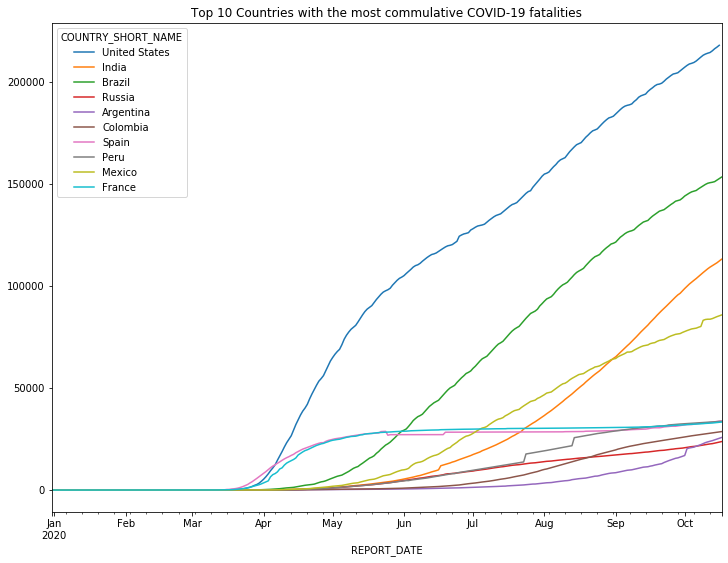

In [9]:
df_cp.xs('PEOPLE_DEATH_COUNT', axis=1, level=0)[top_10c].plot.line(
    figsize=(12,9),
    title="Top 10 Countries with the most commulative COVID-19 fatalities"
);

The graphs below show the growth trends by country. Note that the left axis is not standardized between states so it's important to look at the magnitude.  Also note that this depends on accurate reporting by the countried themselves, which is questionable in some cases.

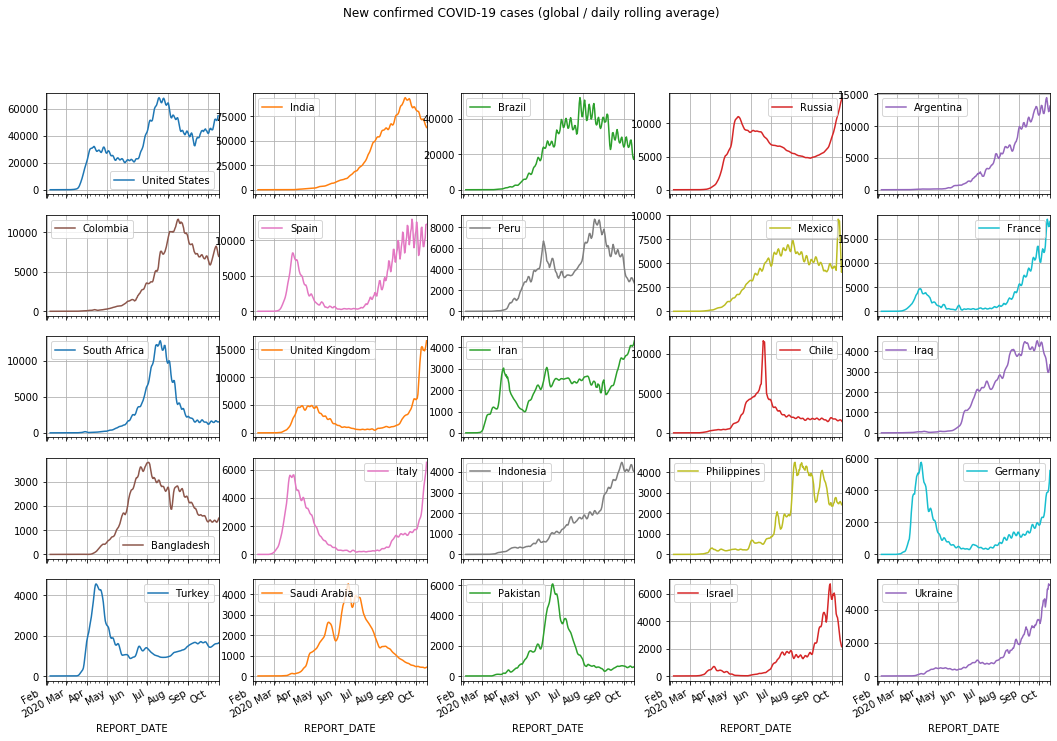

In [10]:
df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[30::][top_25c].rolling(window=5).mean().diff().rolling(3).mean().plot(
    subplots=True, 
#     ylim=(-25,100), 
    grid=True, 
    layout=(5,5), 
    figsize=(18,12), 
#     cmap='tab20',
    title='New confirmed COVID-19 cases (global / daily rolling average)'
);
plt.savefig('./out/covid_cases_global_trends.png');

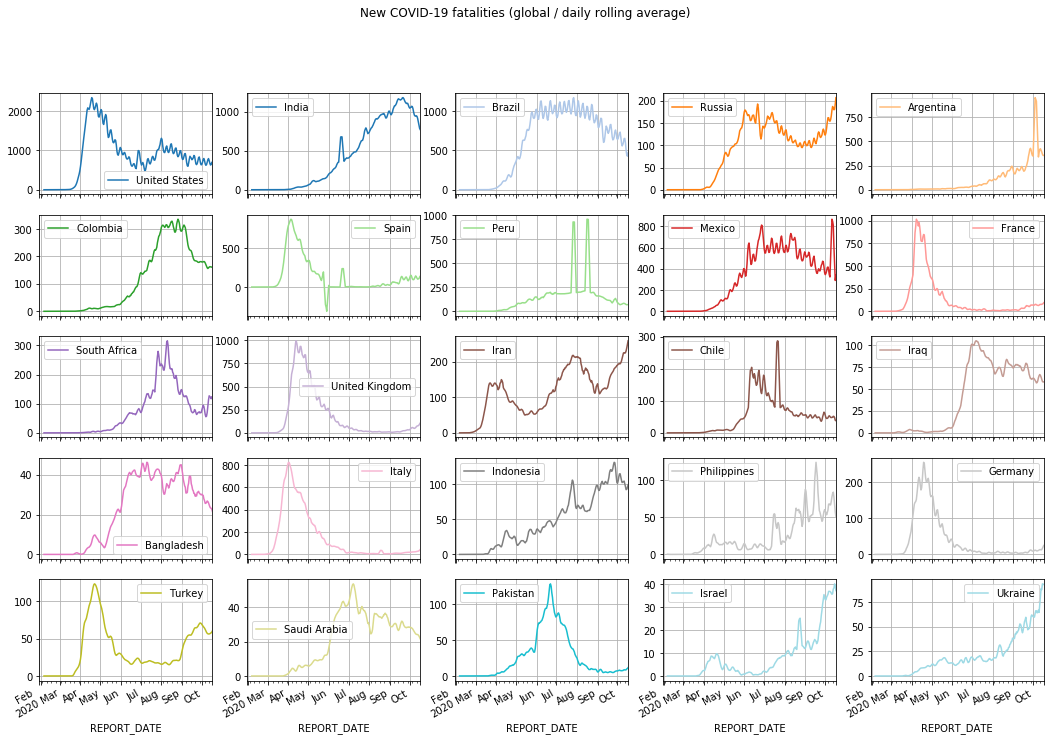

In [11]:
df_cp.xs('PEOPLE_DEATH_COUNT', axis=1, level=0).iloc[30::][top_25c].rolling(window=5).mean().diff().rolling(3).mean().plot(
    subplots=True, 
#     ylim=(-25,100), 
    grid=True, 
    layout=(5,5), 
    figsize=(18,12), 
    cmap='tab20',
    title='New COVID-19 fatalities (global / daily rolling average)'
);
# fig.write_image('./out/covid_deaths_global_trend.png');

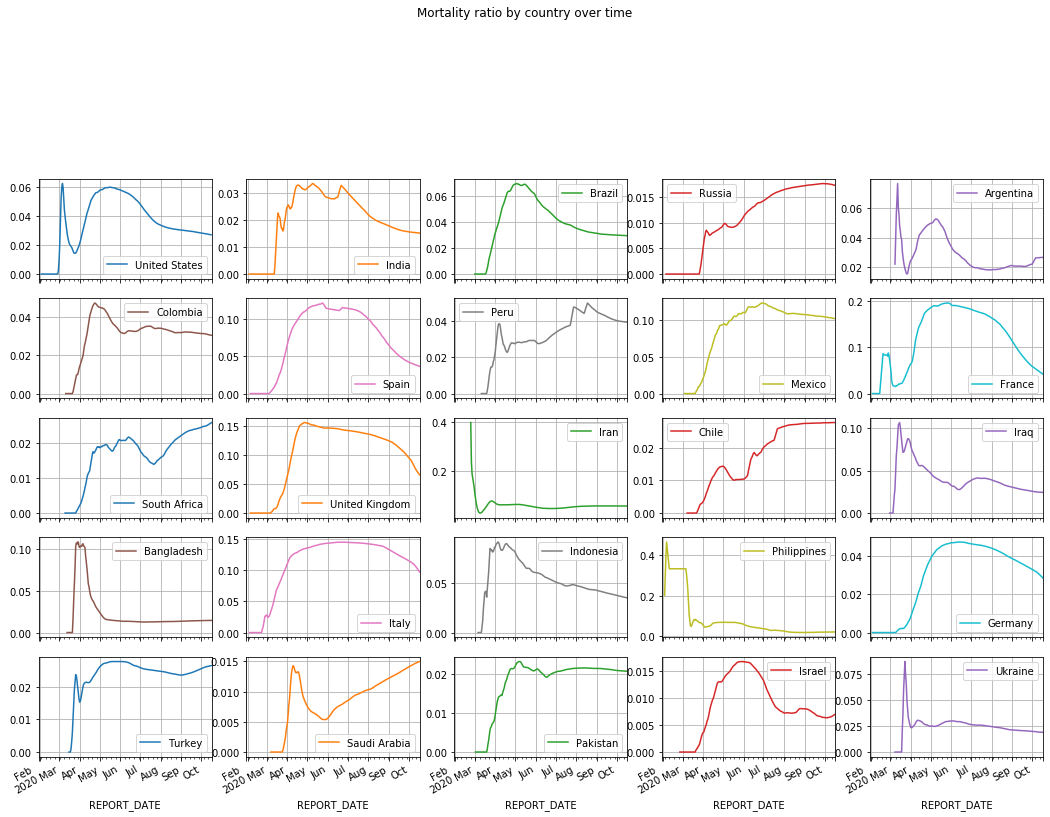

In [12]:
df_cp.xs('MORTALITY_RATIO', axis=1, level=0).iloc[30::][top_25c].rolling(window=5).mean().plot(
    subplots=True, 
#     ylim=(-10,25), 
    layout=(10,5), 
    figsize=(18,24),
    grid=True, 
    title='Mortality ratio by country over time',
);

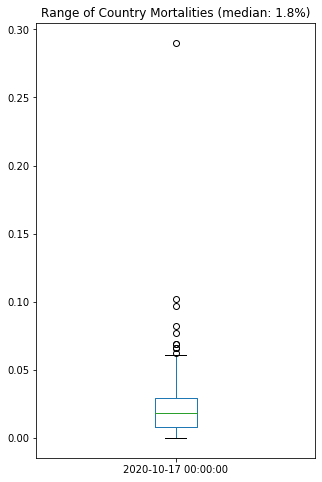

In [14]:
df_cp.xs('MORTALITY_RATIO', axis=1, level=0).iloc[30::].rolling(window=5).mean().iloc[-1].plot.box(
    figsize=(5,8),
    title="Range of Country Mortalities (median: {0:0.1f}%)".format(np.median(df_cp.xs('MORTALITY_RATIO', axis=1, level=0).iloc[30::].rolling(window=5).mean().iloc[-1].fillna(0).values)*100)
);

In [34]:
data = df_cp.xs('MORTALITY_RATIO', axis=1, level=0).iloc[30::].rolling(window=5).mean();
data = data.resample('M').mean().iloc[-5::];
data = data.unstack();
data = data.reset_index();
data.columns=['Country', 'Date', 'Ratio']
data


,Country,Date,Ratio
0,Afghanistan,2020-06-30,0.019
1,Afghanistan,2020-07-31,0.030
2,Afghanistan,2020-08-31,0.036
3,Afghanistan,2020-09-30,0.037
4,Afghanistan,2020-10-31,0.037
...,...,...,...
1025,Zimbabwe,2020-06-30,0.014
1026,Zimbabwe,2020-07-31,0.014
1027,Zimbabwe,2020-08-31,0.024
1028,Zimbabwe,2020-09-30,0.030


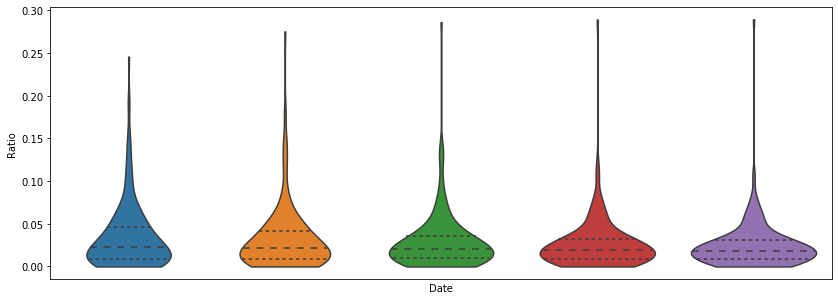

In [40]:
import matplotlib.dates as mdates;
fmt = mdates.DateFormatter('%m')
fig, ax = plt.subplots();
fig.set_size_inches(14, 5);
ax = sns.violinplot(x="Date", y="Ratio", data=data, inner="quartile", cut=0);
ax.xaxis.set_major_locator(mdates.MonthLocator());
ax.xaxis.set_major_formatter(fmt);
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.xticks(rotation=65);
plt.show();
